In [13]:
import numpy as np
import pandas as pd
from IPython.display import clear_output

# 加载数据集。
dftrain = pd.read_csv('./datasets/titanic_train.csv')
dfeval = pd.read_csv('./datasets/titanic_eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

In [14]:
import tensorflow as tf
tf.random.set_seed(123)

In [15]:
fc = tf.feature_column
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

# one-hot encoding
def one_hot_cat_column(feature_name, vocab):
    return fc.indicator_column(fc.categorical_column_with_vocabulary_list(feature_name, vocab))

feature_columns = []

for feature_name in CATEGORICAL_COLUMNS:
    # 需要使用独热编码（one-hot-encoding）处理非数值特征。
    vocabulary = dftrain[feature_name].unique()
    feature_columns.append(one_hot_cat_column(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(fc.numeric_column(feature_name, dtype=tf.float32))
    


## 定义 INPUT 函数，构建 Pipepline

In [16]:
# 当数据集小的时候，将整个数据集作为一个 batch。
NUM_EXAMPLES = len(y_train)

def make_input_fn(dftrain_data, df_train_label, epochs=None, shuffle=True):
    def input_fn():
        dataset = tf.data.Dataset.from_tensor_slices((dict(dftrain_data), df_train_label))
        if shuffle:
            dataset = dataset.shuffle(NUM_EXAMPLES)
        
        # 设置数据的轮数
        dataset = dataset.repeat(epochs)
        
        return dataset.batch(NUM_EXAMPLES)
    return input_fn

# 训练的 input 函数
train_input_fn = make_input_fn(dftrain, y_train, epochs=100)
# 评估的 input 函数
eval_input_fn = make_input_fn(dfeval, y_eval, epochs=1, shuffle=False)

## 训练模型

In [17]:
# boostedTree estimator参数
params = {
  'n_trees': 50,
  'max_depth': 3,
  'n_batches_per_layer': 1,
  # 为了得到 DFCs，请设置 center_bias = True。这将强制
  # 模型在使用特征（例如：回归中训练集标签的均值，分类中使
  # 用交叉熵损失函数时的对数几率）前做一个初始预测。
  'center_bias': True
}

# 创建 boostedtree classifier estimator
est = tf.estimator.BoostedTreesClassifier(feature_columns, **params)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/84/00xxzv8x4qgdx0bmh22wvhs40000gn/T/tmplq_4fbja', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [18]:
# 训练模型。
est.train(train_input_fn, max_steps=100)

# 评估。
results = est.evaluate(eval_input_fn)
clear_output()
pd.Series(results).to_frame()

,0
accuracy,0.803030
accuracy_baseline,0.625000
auc,0.868503
auc_precision_recall,0.850332
average_loss,0.418216
label/mean,0.375000
loss,0.418216
precision,0.752688
prediction/mean,0.386066
recall,0.707071


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
sns_colors = sns.color_palette('colorblind')

## 局部可解释性（Local interpretability）

In [21]:
pred_dicts = list(est.experimental_predict_with_explanations(eval_input_fn))

INFO:tensorflow:Using config: {'_model_dir': '/var/folders/84/00xxzv8x4qgdx0bmh22wvhs40000gn/T/tmplq_4fbja', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
I

In [22]:
# 创建 DFCs 的 DataFrame。
labels = y_eval.values
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])
df_dfc = pd.DataFrame([pred['dfc'] for pred in pred_dicts])
df_dfc.describe().T

,count,mean,std,min,25%,50%,75%,max
age,264.0,-0.027495,0.081316,-0.131149,-0.075852,-0.057065,0.001871,0.362808
sex,264.0,0.006366,0.105262,-0.095331,-0.073342,-0.071955,0.135797,0.180123
class,264.0,0.017609,0.092234,-0.110928,-0.043703,-0.042149,0.031722,0.226018
deck,264.0,-0.018748,0.028524,-0.069503,-0.043095,-0.032967,0.000794,0.148511
embark_town,264.0,-0.006035,0.028324,-0.051901,-0.015263,-0.012865,-0.003306,0.079991
fare,264.0,0.025457,0.084493,-0.193280,-0.023867,-0.005431,0.053784,0.241879
n_siblings_spouses,264.0,0.001130,0.018206,-0.105798,0.001961,0.002312,0.004314,0.062579
parch,264.0,0.000222,0.007458,-0.055613,0.000552,0.000669,0.001185,0.040072
alone,264.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [23]:
# DFCs的和 + 偏差（bias） == 可能性
bias = pred_dicts[0]['bias']
dfc_prob = df_dfc.sum(axis=1) + bias
np.testing.assert_almost_equal(dfc_prob.values,
                               probs.values)

In [24]:
# 绘制模版 :)
def _get_color(value):
    """正的 DFCs 标为绿色，负的为红色。"""
    green, red = sns.color_palette()[2:4]
    if value >= 0: return green
    return red

def _add_feature_values(feature_values, ax):
    """在图的左侧显示特征的值"""
    x_coord = ax.get_xlim()[0]
    OFFSET = 0.15
    for y_coord, (feat_name, feat_val) in enumerate(feature_values.items()):
        t = plt.text(x_coord, y_coord - OFFSET, '{}'.format(feat_val), size=12)
        t.set_bbox(dict(facecolor='white', alpha=0.5))
    from matplotlib.font_manager import FontProperties
    font = FontProperties()
    font.set_weight('bold')
    t = plt.text(x_coord, y_coord + 1 - OFFSET, 'feature\nvalue',
    fontproperties=font, size=12)

def plot_example(example):
    TOP_N = 8 # 显示前8个特征。
    sorted_ix = example.abs().sort_values()[-TOP_N:].index  # 按值排序。
    example = example[sorted_ix]
    colors = example.map(_get_color).tolist()
    ax = example.to_frame().plot(kind='barh',
                                 color=[colors],
                                 legend=None,
                                 alpha=0.75,
                                 figsize=(10,6))
    ax.grid(False, axis='y')
    ax.set_yticklabels(ax.get_yticklabels(), size=14)

    # 添加特征的值。
    _add_feature_values(dfeval.iloc[ID][sorted_ix], ax)
    return ax

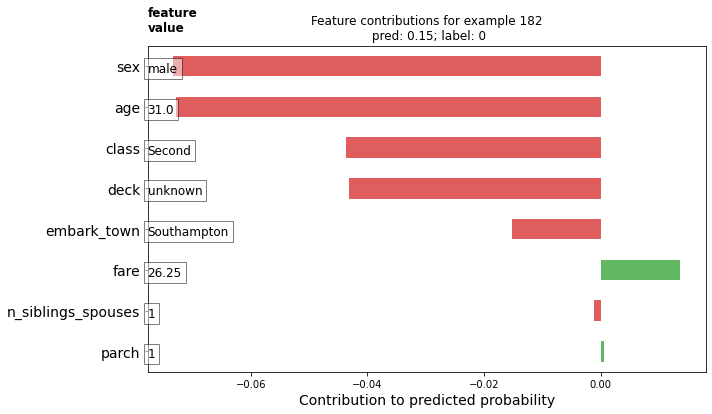

In [25]:
# 绘制结果。
ID = 182
example = df_dfc.iloc[ID]  # 从评估集中选择第 i 个样例。
TOP_N = 8  # 显示前8个特征。
sorted_ix = example.abs().sort_values()[-TOP_N:].index
ax = plot_example(example)
ax.set_title('Feature contributions for example {}\n pred: {:1.2f}; label: {}'.format(ID, probs[ID], labels[ID]))
ax.set_xlabel('Contribution to predicted probability', size=14)
plt.show()

In [26]:
# 绘制代码模版。
def dist_violin_plot(df_dfc, ID):
    # 初始化画布。
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    # 创建样例 DataFrame。
    TOP_N = 8  # 显示前8个特征。
    example = df_dfc.iloc[ID]
    ix = example.abs().sort_values()[-TOP_N:].index
    example = example[ix]
    example_df = example.to_frame(name='dfc')

    # 添加整个分布的贡献。
    parts=ax.violinplot([df_dfc[w] for w in ix],
                        vert=False,
                        showextrema=False,
                        widths=0.7,
                        positions=np.arange(len(ix)))
    face_color = sns_colors[0]
    alpha = 0.15
    for pc in parts['bodies']:
        pc.set_facecolor(face_color)
        pc.set_alpha(alpha)

    # 添加特征的值。
    _add_feature_values(dfeval.iloc[ID][sorted_ix], ax)

    # 添加局部贡献。
    ax.scatter(example,
               np.arange(example.shape[0]),
               color=sns.color_palette()[2],
               s=100,
               marker="s",
               label='contributions for example')

    # 图例。
    # 生成小提琴图的详细图例。
    ax.plot([0,0], 
            [1,1], 
            label='eval set contributions\ndistributions',
            color=face_color, 
            alpha=alpha, 
            linewidth=10)
    
    legend = ax.legend(loc='lower right', 
                       shadow=True, 
                       fontsize='x-large',
                       frameon=True)
    legend.get_frame().set_facecolor('white')

    # 调整格式。
    ax.set_yticks(np.arange(example.shape[0]))
    ax.set_yticklabels(example.index)
    ax.grid(False, axis='y')
    ax.set_xlabel('Contribution to predicted probability', size=14)

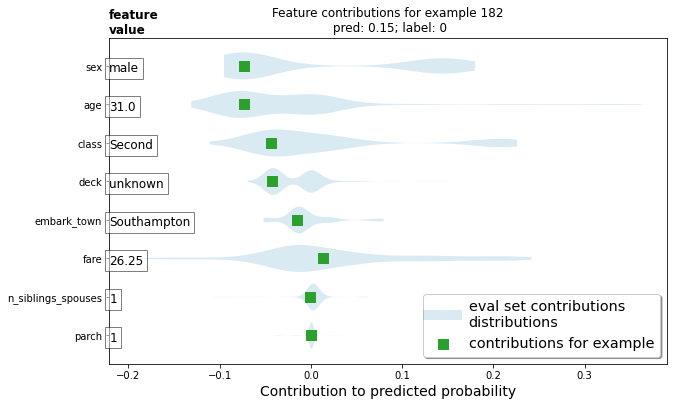

In [27]:
dist_violin_plot(df_dfc, ID)
plt.title('Feature contributions for example {}\n pred: {:1.2f}; label: {}'.format(ID, probs[ID], labels[ID]))
plt.show()

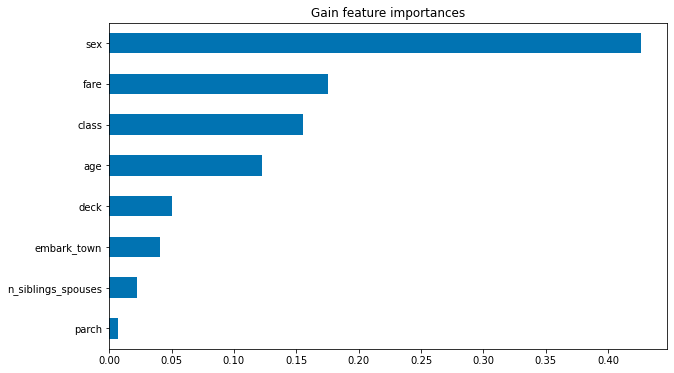

In [28]:
importances = est.experimental_feature_importances(normalize=True)
df_imp = pd.Series(importances)

# 可视化重要性。
N = 8
ax = (df_imp.iloc[0:N][::-1]
    .plot(kind='barh',
          color=sns_colors[0],
          title='Gain feature importances',
          figsize=(10, 6)))
ax.grid(False, axis='y')

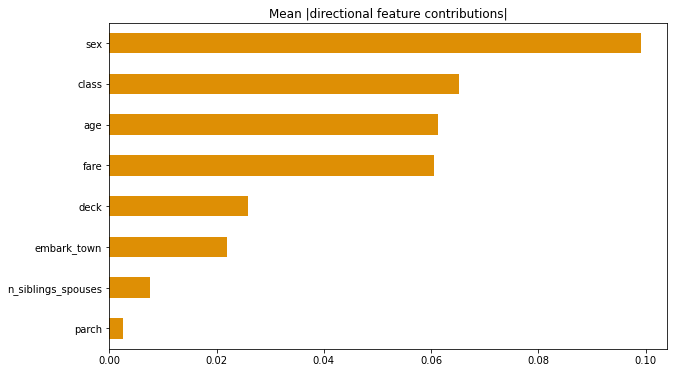

In [29]:
# 绘图。
dfc_mean = df_dfc.abs().mean()
N = 8
sorted_ix = dfc_mean.abs().sort_values()[-N:].index  # 求平均并按绝对值排序。
ax = dfc_mean[sorted_ix].plot(kind='barh',
                       color=sns_colors[1],
                       title='Mean |directional feature contributions|',
                       figsize=(10, 6))
ax.grid(False, axis='y')

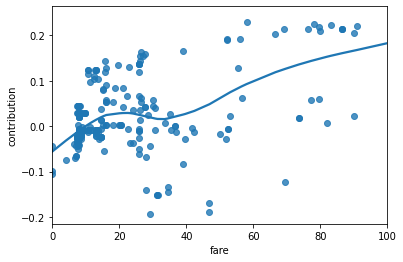

In [31]:
FEATURE = 'fare'
feature = pd.Series(df_dfc[FEATURE].values, index=dfeval[FEATURE].values).sort_index()
ax = sns.regplot(feature.index.values, feature.values, lowess=True)
ax.set_ylabel('contribution')
ax.set_xlabel(FEATURE)
ax.set_xlim(0, 100)
plt.show()

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-12-05T10:41:35Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/84/00xxzv8x4qgdx0bmh22wvhs40000gn/T/tmplq_4fbja/model.ckpt-99
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.56313s
INFO:tensorflow:Finished evaluation at 2020-12-05-10:41:36
INFO:tensorflow:Saving dict for global step 99: accuracy = 0.8030303, accuracy_baseline = 0.625, auc = 0.8685033, auc_precision_recall = 0.85033214, average_loss = 0.41821602, global_step = 99, label/mean = 0.375, loss = 0.41821602, precision = 0.75268817, prediction/mean = 0.3860662, recall = 0.7070707
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 99: /var/folders/84/00xxzv8x4qgdx0bmh22wvhs40000gn/T/tmplq_4fbja/model.ckpt-99
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:te

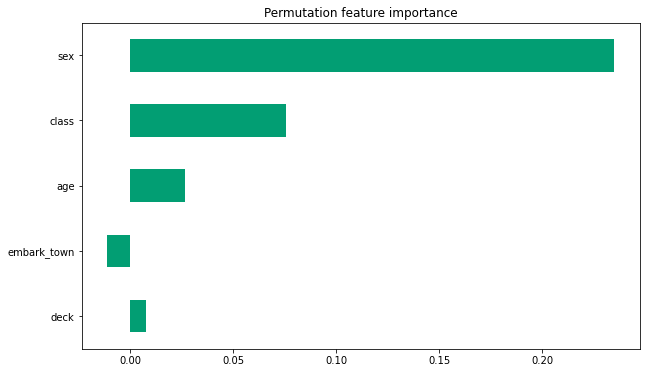

In [33]:
def permutation_importances(est, X_eval, y_eval, metric, features):
    """
    分别对每列，打散列中的值并观察其对评估集的影响。

    在训练过程中，有一种类似的方法，请参阅文章（来源：http://explained.ai/rf-importance/index.html）
    中有关 “Drop-column importance” 的部分。
    """
    baseline = metric(est, X_eval, y_eval)
    imp = []
    for col in features:
        save = X_eval[col].copy()
        X_eval[col] = np.random.permutation(X_eval[col])
        m = metric(est, X_eval, y_eval)
        X_eval[col] = save
        imp.append(baseline - m)
    return np.array(imp)

def accuracy_metric(est, X, y):
    """TensorFlow 估算器精度"""
    eval_input_fn = make_input_fn(X,
                                  y,
                                  shuffle=False,
                                  epochs=1)
    return est.evaluate(input_fn=eval_input_fn)['accuracy']

features = CATEGORICAL_COLUMNS + NUMERIC_COLUMNS
importances = permutation_importances(est, dfeval, y_eval, accuracy_metric,
                                      features)
df_imp = pd.Series(importances, index=features)

sorted_ix = df_imp.abs().sort_values().index
ax = df_imp[sorted_ix][-5:].plot(kind='barh', color=sns_colors[2], figsize=(10, 6))
ax.grid(False, axis='y')
ax.set_title('Permutation feature importance')
plt.show()

In [34]:
from numpy.random import uniform, seed
from scipy.interpolate import griddata

# 生成数据。
seed(0)
npts = 5000
x = uniform(-2, 2, npts)
y = uniform(-2, 2, npts)
z = x*np.exp(-x**2 - y**2)
xy = np.zeros((2,np.size(x)))
xy[0] = x
xy[1] = y
xy = xy.T

In [37]:
# 准备用于训练的数据。
df = pd.DataFrame({'x': x, 'y': y, 'z': z})

xi = np.linspace(-2.0, 2.0, 200),
yi = np.linspace(-2.1, 2.1, 210),
xi,yi = np.meshgrid(xi, yi)

df_predict = pd.DataFrame({
    'x' : xi.flatten(),
    'y' : yi.flatten(),
})
predict_shape = xi.shape



In [38]:
def plot_contour(x, y, z, **kwargs):
    # 准备用于训练的数据。
    plt.figure(figsize=(10, 8))
    # 绘制等值线图，标出非均匀数据点。
    CS = plt.contour(x, y, z, 15, linewidths=0.5, colors='k')
    CS = plt.contourf(x, y, z, 15,
                      vmax=abs(zi).max(), vmin=-abs(zi).max(), cmap='RdBu_r')
    plt.colorbar()  # 绘制颜色图例。
    # 绘制数据点。
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)

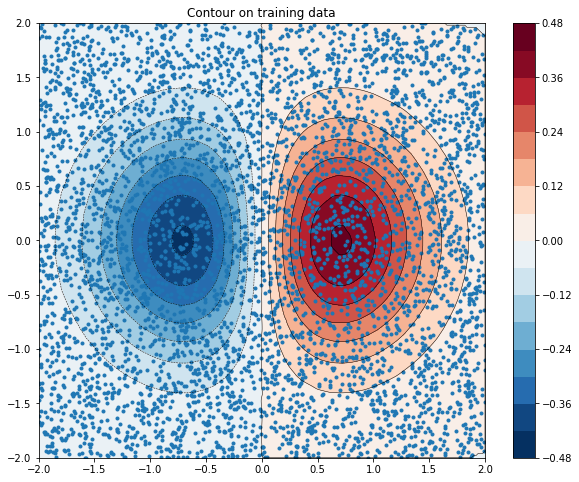

In [39]:
zi = griddata(xy, z, (xi, yi), method='linear', fill_value='0')
plot_contour(xi, yi, zi)
plt.scatter(df.x, df.y, marker='.')
plt.title('Contour on training data')
plt.show()

In [40]:
fc = [tf.feature_column.numeric_column('x'),
      tf.feature_column.numeric_column('y')]

In [42]:
def predict(est):
    """已有估算器给出的预测"""
    predict_input_fn = lambda: tf.data.Dataset.from_tensors(dict(df_predict))
    preds = np.array([p['predictions'][0] for p in est.predict(predict_input_fn)])
    return preds.reshape(predict_shape)


In [43]:
train_input_fn = make_input_fn(df, df.z)
est = tf.estimator.LinearRegressor(fc)
est.train(train_input_fn, max_steps=500);

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/84/00xxzv8x4qgdx0bmh22wvhs40000gn/T/tmp1gfcf0md', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in f

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/84/00xxzv8x4qgdx0bmh22wvhs40000gn/T/tmp1gfcf0md/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


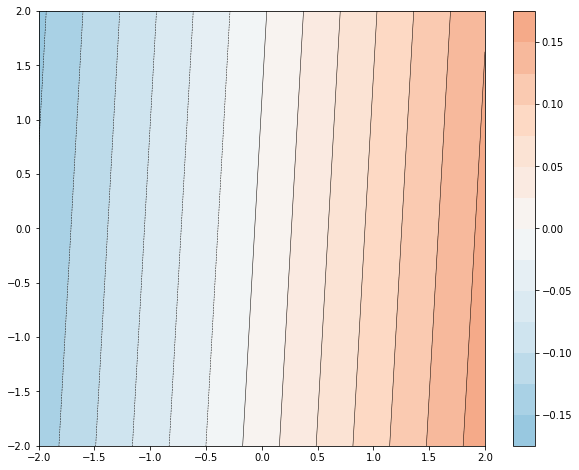

In [44]:
plot_contour(xi, yi, predict(est))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/84/00xxzv8x4qgdx0bmh22wvhs40000gn/T/tmp9s41q9g5/model.ckpt-222
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


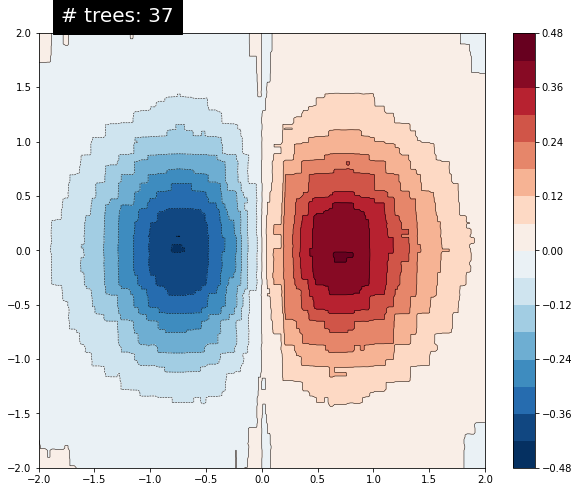

In [45]:
n_trees = 37 

est = tf.estimator.BoostedTreesRegressor(fc, n_batches_per_layer=1, n_trees=n_trees)
est.train(train_input_fn, max_steps=500)
clear_output()
plot_contour(xi, yi, predict(est))
plt.text(-1.8, 2.1, '# trees: {}'.format(n_trees), color='w', backgroundcolor='black', size=20)
plt.show()